# Stop Detection User Guide

## Introduction

In this notebook we will explore some stop detection algorithms implemented in `nomad`.

## Quick Start

### Load data 

In [1]:
%matplotlib inline
import nomad.io.base as loader
import geopandas as gpd
from shapely.geometry import Polygon, box, Point
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import shapely.plotting as shp_plt
from IPython.display import HTML
from nomad.stop_detection.viz import adjust_zoom, plot_stops_barcode, plot_pings, plot_stops, plot_time_barcode
import nomad.stop_detection.dbscan as DBSCAN
import nomad.stop_detection.lachesis as LACHESIS
import nomad.stop_detection.grid_based as GRID_BASED
import nomad.filters as filters 
import h3

city = gpd.read_file("garden_city.geojson").to_crs('EPSG:3857')
outer_box = box(*city.total_bounds).buffer(15, join_style='mitre')

filepath_root = 'gc_data_long/'
tc = {
    "user_id": "gc_identifier",
    "timestamp": "unix_ts",
    "x": "dev_x",
    "y": "dev_y",
    "ha":"ha",
    "date":"date"}

users = ['admiring_brattain']
traj = loader.sample_from_file(filepath_root, format='parquet', users=users, filters = ('date','==', '2024-01-01'), traj_cols=tc)

## Algorithm Details

### Lachesis (Sequential Stop Detection)

The first stop detection algorithm implemented in ```nomad``` is a sequential algorithm insipired by the one in _Project Lachesis: Parsing and Modeling Location Histories_ (Hariharan & Toyama). This algorithm for extracting stays is dependent on two parameters: the roaming distance and the stay duration. 

dur_min
* `delta_roam` is the Roaming distance ($\Delta_{\texttt{max}}$) represents the maximum distance an object can move away from a point location and still be considered to be staying at that location.
* `dur_min` is a minimum stop duration below which we consider the stop to be (potentially) spurious
* ```dt_max```: Maximum time gap permitted between consecutive pings in a stay in minutes (dt_max should be greater than dur_min).

The algorithm identifies stops as contiguous sequences of pings that have a diameter less than `delta_roam` for at least the duration of the stop duration.

The stop detection algorithms implemented in `nomad` support different combinations of input formats that are common in commercial datasets, detecting default names when possible
- timestamps in `datetime64[ns, tz]` or as unix seconds in integers
- geographic coordinates (`lon`, `lat`) which use the Haversine distance or projected coordinates (`x`, `y`) using meters and euclidean distance.
- Alternatively, if locations are only given through a spatial index like H3 or geohash, there is a **grid_based** clustering algorithm requiring no coordinates. 

The algorithms work with the same call, provided there is at least a pair of coordinates (or a location/spatial index) as well as at least a temporal column.

In [3]:
stops = LACHESIS.lachesis(traj, delta_roam=20, dt_max = 60, dur_min=5, complete_output=True, traj_cols=tc)
stops

KeyError: "None of [Index(['x', 'y'], dtype='object')] are in the [columns]"

C:\Users\pacob\Documents\repositories\nomad-repo\nomad\io\base.py:107: UserWarning: Trajectory column 'x' specified for 'x' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
C:\Users\pacob\Documents\repositories\nomad-repo\nomad\io\base.py:107: UserWarning: Trajectory column 'y' specified for 'y' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")


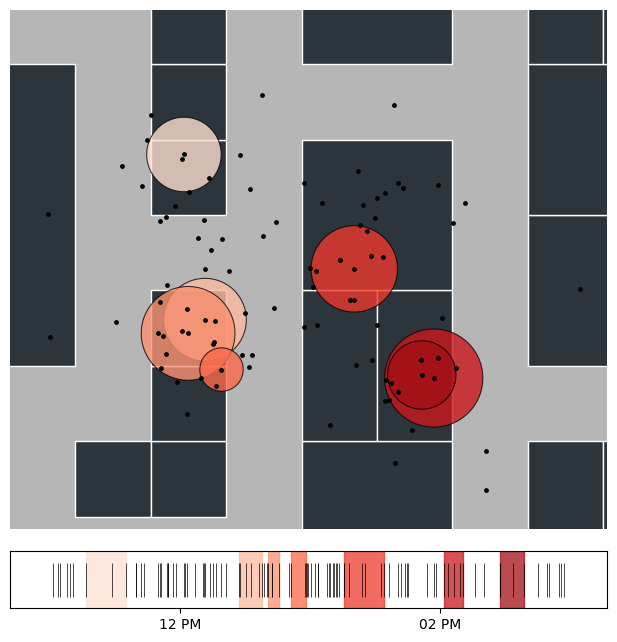

In [11]:
fig, (ax_map, ax_barcode) = plt.subplots(2, 1, figsize=(6,6.5),
                                         gridspec_kw={'height_ratios':[10,1]})

shp_plt.plot_polygon(outer_box, ax=ax_map, add_points=False, color='#0e0e0e')
city.plot(ax=ax_map, edgecolor='white', linewidth=1, color='#2c353c')

plot_stops(stops, ax=ax_map, cmap='Reds', x='dev_x', y='dev_y')
plot_pings(traj, ax=ax_map, s=6, point_color='black', cmap='twilight', traj_cols=tc)

adjust_zoom(stops['dev_x'], stops['dev_y'], buffer=1.4, ax=ax_map)
ax_map.set_axis_off()

plot_time_barcode(traj[tc['timestamp']], ax=ax_barcode, set_xlim=True)
plot_stops_barcode(stops, ax=ax_barcode, cmap='Reds', set_xlim=False, x='x', y='y', timestamp='unix_ts')

plt.tight_layout(pad=0.1)
plt.show()

### Density based stop detection (Temporal DBSCAN)

The second stop detection algorithm implemented in ```nomad``` is an adaptation of DBSCAN. Unlike in plain DBSCAN, we also incorporate the time dimension to determine if two pings are "neighbors". This implementation relies on 3 parameters

* `time_thresh` defines the maximum time difference (in minutes) between two consecutive pings for them to be considered neighbors within the same cluster.
* `dist_thresh` specifies the maximum spatial distance (in meters) between two pings for them to be considered neighbors.
* `min_pts` sets the minimum number of neighbors required for a ping to form a cluster.

Notice that this method also works with **geographic coordinates** (lon, lat), using Haversine distance. 

In [13]:
users = ['confident_aryabhata']
traj = loader.sample_from_file(filepath_root, format='parquet', users=users, filters = ('date','<=', '2024-01-03'), traj_cols=tc)
traj[['longitude','latitude']] = np.column_stack(
    filters.to_projection(traj, x='dev_x', y='dev_y', data_crs='EPSG:3857', crs_to='EPSG:4326')
)

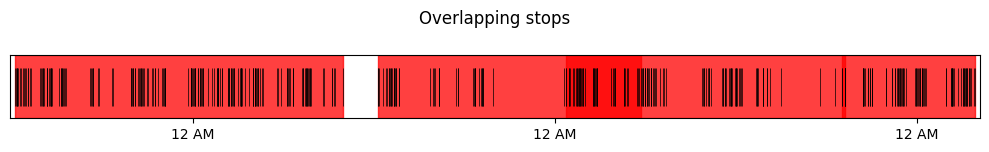

In [14]:
stops_dbscan = DBSCAN.ta_dbscan(traj,
                    time_thresh=720,
                    dist_thresh=15,
                    min_pts=3,
                    complete_output=True,
                    traj_cols=tc)

fig, ax_barcode = plt.subplots(figsize=(10,1.5))

plot_time_barcode(traj['unix_ts'], ax=ax_barcode, set_xlim=True)
plot_stops_barcode(stops_dbscan, ax=ax_barcode, stop_color='red', set_xlim=False, timestamp='unix_ts')
fig.suptitle("Overlapping stops")
plt.tight_layout()
plt.show()

## Spatial-only algorithms can produce (temporally) invalid stop tables

While the parameter `time_thresh` helps mitigate this issue (this would be *pre-processing*). It seems like some post-processing is necessary to "break up" temporally overlapping stops. 

One way is to use a **sequential location-based algorithm**, using DBSCAN's cluster labels **as "locations"**. For this we need the **disaggregated output** of the stop-detection algorithm

In [ ]:
traj["cluster"] = DBSCAN.ta_dbscan_labels(traj,
                    time_thresh=720,
                    dist_thresh=15,
                    min_pts=3,
                    traj_cols=tc)

In [ ]:
from nomad.stop_detection.utils import summarize_stop
import nomad.stop_detection.postprocessing as post

new_cluster = GRID_BASED.grid_based_labels(
                        data=traj.loc[traj.cluster!=-1], # except noise pings
                        time_thresh=720,
                        min_cluster_size=3,
                        location_id="cluster", # grid_based requires a location column
                        traj_cols=tc)

traj.loc[traj.cluster!=-1, 'cluster'] = new_cluster

In [ ]:
post_processed_stops = [
        summarize_stop(
            grouped_data=group,
            keep_col_names=True,
            complete_output=True,
            traj_cols=tc,
            passthrough_cols = ['cluster', 'gc_identifier']
        )
        for _, group in traj.loc[traj.cluster!=-1].groupby('cluster', as_index=False, sort=False)
    ]
post_processed_stops = pd.DataFrame(post_processed_stops)

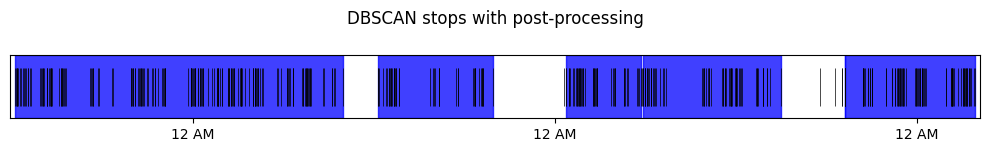

In [20]:
fig, ax_barcode = plt.subplots(figsize=(10,1.5))

plot_time_barcode(traj['unix_ts'], ax=ax_barcode, set_xlim=True)
plot_stops_barcode(post_processed_stops, ax=ax_barcode, stop_color='blue', set_xlim=False, timestamp='unix_ts')
fig.suptitle("DBSCAN stops with post-processing")
plt.tight_layout()
plt.show()

## Which algorithm to choose? Which parameters

This is not a trivial problem and researchers often rely on "trial and error" or, worse, default parameters. A semi-informed choice could depend on:


| Factor | Implication |
| --- | --- |
| Signal sparsity | Denser data → increase DBSCAN `min_pts` to prevent over‑clustering |
| Noise level | Higher noise (low accuracy) → use larger distance thresholds |
| Building proximity | Dense areas → use smaller distance thresholds |
| Scalability | More robust methods → longer execution time |

We could do **a parameter search** by keeping track of some statistics of the output of several stop detection algorithms

In [42]:
tc = {
    "user_id": "gc_identifier",
    "timestamp": "unix_ts",
    "x": "dev_x",
    "y": "dev_y",
    "ha":"ha",
    "date":"date"}

In [43]:
traj = loader.sample_from_file(filepath_root, frac_users=0.1, format='parquet', traj_cols=tc, seed=10) # try frac_users = 0.1
# H3 cells for grid_based stop detection method
# traj['h3_cell'] = filters.to_tessellation(traj, index="h3", res=10, x='dev_x', y='dev_y', input_crs='EPSG:3857', data_crs='EPSG:3857')
pings_per_user = traj['gc_identifier'].value_counts()

In [ ]:
import time
from tqdm import tqdm
import nomad.stop_detection.hdbscan as HDBSCAN

# Approximately 5 minutes for 40 users
results = []
for user, n_pings in tqdm(pings_per_user.items(), total=len(pings_per_user)):
    user_data = traj.query("gc_identifier == @user")

    # For location based
    start_time = time.time()
    stops_gb = GRID_BASED.grid_based(user_data, time_thresh=240, complete_output=True, timestamp='unix_ts', location_id='h3_cell')
    execution_time = time.time() - start_time
    results += [pd.Series({'user':user, 'algo':'grid_based', 'execution_time':execution_time, 'total_dwell':stops_gb.duration.sum(), 'avg_diameter':52, 'n_pings':n_pings})]
    
    # For Lachesis
    start_time = time.time()
    stops_lac = LACHESIS.lachesis(user_data, delta_roam=30, dt_max=240, complete_output=True, traj_cols=tc)
    execution_time = time.time() - start_time
    results += [pd.Series({'user':user, 'algo':'lachesis', 'execution_time':execution_time, 'total_dwell':stops_lac.duration.sum(), 'avg_diameter':stops_lac.diameter.mean(), 'n_pings':n_pings})]

    # For TADbscan
    start_time = time.time()
    user_data_tadb = user_data.assign(cluster=DBSCAN.ta_dbscan_labels(user_data, time_thresh=240, dist_thresh=15, min_pts=3, traj_cols=tc))
    # - post-processing
    stops_tadb = post.remove_overlaps(user_data_tadb, time_thresh=240, method='cluster', traj_cols=tc)
    execution_time = time.time() - start_time
    results += [pd.Series({'user':user, 'algo':'tadbscan', 'execution_time':execution_time, 'total_dwell':stops_tadb.duration.sum(), 'avg_diameter':stops_tadb.diameter.mean(), 'n_pings':n_pings})]

    # For HDBSCAN
    start_time = time.time()
    user_data_hdb = user_data.assign(cluster=HDBSCAN.st_hdbscan_labels(user_data, time_thresh=240, min_pts=3, min_cluster_size=2, traj_cols=tc))
    # - post-processing
    stops_hdb = post.remove_overlaps(user_data_hdb, time_thresh=240, method='cluster', traj_cols=tc)    
    execution_time = time.time() - start_time
    results += [pd.Series({'user':user, 'algo':'hdbscan', 'execution_time':execution_time, 'total_dwell':stops_hdb.duration.sum(), 'avg_diameter':stops_hdb.diameter.mean(), 'n_pings':n_pings})]

results = pd.DataFrame(results)

  0%|          | 0/35 [00:00<?, ?it/s]



ValueError: Too many user provided spatial columns in arguments {}, only one pair of spatial coordinates is required.

### Use **completeness to normalize** ('hrs with data' / 'total hrs')

In [27]:
completeness_per_user = filters.completeness(traj, timestamp='unix_ts', user_id='gc_identifier')
dwell_scaling = 1/completeness_per_user
dwell_scaling.name = 'dwell_scaling'

metrics = pd.merge(results, dwell_scaling, left_on='user', right_index=True)
metrics['rescaled_total_dwell'] = (metrics['total_dwell']/60)*metrics['dwell_scaling'] # in hours

C:\Users\franc\AppData\Local\Temp\ipykernel_18452\905775351.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=metrics, x='avg_diameter', hue='algo', ax=axes[1], common_norm=False, bw_adjust=2)


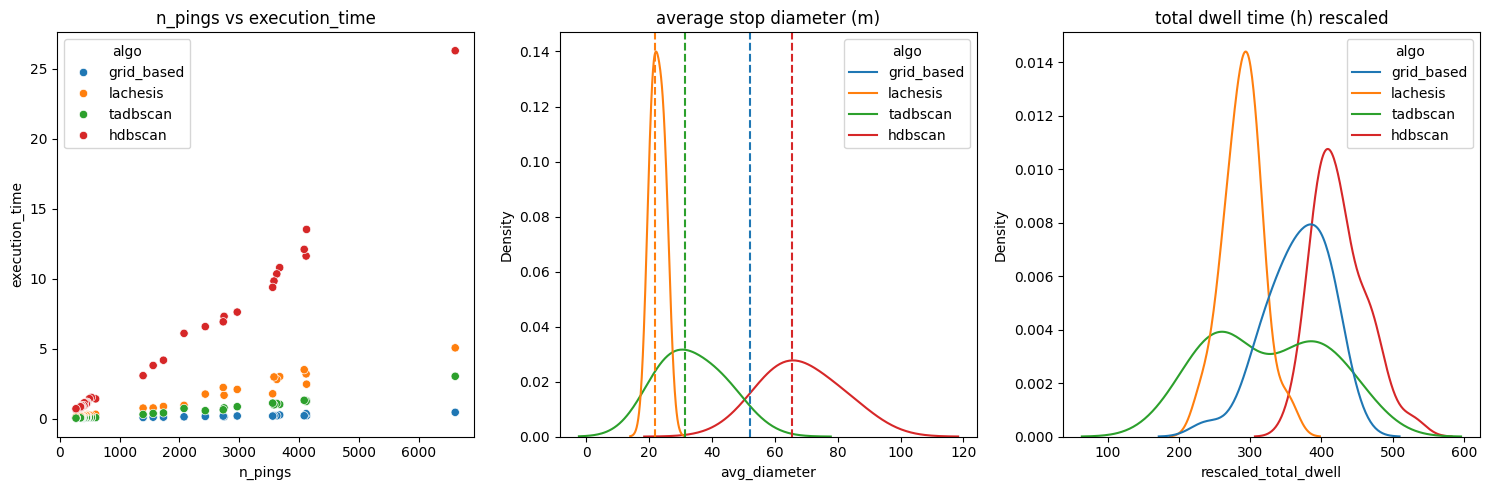

In [28]:
import seaborn as sns

algos = ['grid_based', 'lachesis', 'tadbscan', 'hdbscan']
palette = dict(zip(algos, sns.color_palette(n_colors=len(algos))))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# scatter: n_pings vs execution_time
sns.scatterplot(data=metrics, x='n_pings', y='execution_time', hue='algo', ax=axes[0])
axes[0].set_title('n_pings vs execution_time')

# density: avg_diameter
sns.kdeplot(data=metrics, x='avg_diameter', hue='algo', ax=axes[1], common_norm=False, bw_adjust=2)
for algo, color in palette.items():
    med = metrics.loc[metrics.algo == algo, 'avg_diameter'].median()
    axes[1].axvline(med, color=color, linestyle='--')
    
axes[1].set_title('average stop diameter (m)')

# density: rescaled_total_dwell
sns.kdeplot(data=metrics, x='rescaled_total_dwell', hue='algo', ax=axes[2], common_norm=False)
axes[2].set_title('total dwell time (h) rescaled')

plt.tight_layout()
plt.show()

## Benchmarking

In [ ]:
# For just one user
user_id = 'admiring_brattain'
metrics_one_user = metrics[metrics['user'] == user_id]

# scatter: n_pings vs execution_time
plt.figure(figsize=(6, 4))
sns.scatterplot(data=metrics_one_user, x='n_pings', y='execution_time', hue='algo', s=100)
plt.title(f'n_pings vs execution_time for user: {user_id}')
plt.xlabel('Number of pings')
plt.ylabel('Execution time (s)')
plt.legend(title='Algorithm')
plt.tight_layout()
plt.show()

In [ ]:
# Calculate number of hours of sparse data for each run (per algorithm) for a single user
user_id = 'admiring_brattain'
metrics_one_user = metrics[metrics['user'] == user_id].copy()

# If you have a 'traj' DataFrame with all pings for this user:
user_traj = traj[traj['gc_identifier'] == user_id]
n_hours = (user_traj['unix_ts'].max() - user_traj['unix_ts'].min()) / 3600
metrics_one_user['n_hours'] = n_hours

# Plot: number of hours of sparse data vs execution time
plt.figure(figsize=(6, 4))
sns.scatterplot(data=metrics_one_user, x='n_hours', y='execution_time', hue='algo', s=100)
plt.title(f'Input time window (hours) vs execution_time for user: {user_id}')
plt.xlabel('Number of hours of sparse data')
plt.ylabel('Execution time (s)')
plt.legend(title='Algorithm')
plt.tight_layout()
plt.show()

In [ ]:
user_id = 'admiring_brattain'
user_data = traj[traj['gc_identifier'] == user_id]

# --- Lachesis: No explicit graph, but you can time the main clustering step
start = time.time()
stops_lac = LACHESIS.lachesis(user_data, delta_roam=30, dt_max=240, complete_output=True, traj_cols=tc)
lachesis_time = time.time() - start

# --- Temporal DBSCAN: Graph construction (_find_neighbors) and clustering
from nomad.stop_detection.ta_dbscan import _find_neighbors

start = time.time()
t_key, coord_key1, coord_key2, use_datetime, use_lon_lat = DBSCAN.utils._fallback_st_cols(user_data.columns, tc, {})
neighbors = _find_neighbors(user_data, time_thresh=240, dist_thresh=15, use_lon_lat=use_lon_lat, use_datetime=use_datetime, traj_cols=tc)
graph_time = time.time() - start

start = time.time()
user_data_tadb = user_data.assign(cluster=DBSCAN.ta_dbscan_labels(user_data, time_thresh=240, dist_thresh=15, min_pts=3, traj_cols=tc))
clustering_time = time.time() - start

start = time.time()
stops_tadb = post.remove_overlaps(user_data_tadb, time_thresh=240, method='cluster', traj_cols=tc)
postproc_time = time.time() - start

print(f"Lachesis clustering: {lachesis_time:.3f}s")
print(f"TADbscan graph construction: {graph_time:.3f}s")
print(f"TADbscan clustering: {clustering_time:.3f}s")
print(f"TADbscan post-processing: {postproc_time:.3f}s")

# --- HDBSCAN: Graph construction and clustering
import nomad.stop_detection.hdbscan as HDBSCAN

start = time.time()
labels_hdb = HDBSCAN.st_hdbscan_labels(user_data, time_thresh=240, min_pts=3, min_cluster_size=2, traj_cols=tc)
hdbscan_time = time.time() - start

start = time.time()
user_data_hdb = user_data.assign(cluster=labels_hdb)
stops_hdb = post.remove_overlaps(user_data_hdb, time_thresh=240, method='cluster', traj_cols=tc)
hdbscan_postproc_time = time.time() - start

print(f"HDBSCAN clustering: {hdbscan_time:.3f}s")
print(f"HDBSCAN post-processing: {hdbscan_postproc_time:.3f}s")